## Setup a development environment

Create new Python 3 conda environment, (-n)ame can be anything.
```
conda create -n <environment_name> python=3 -y
```

Activate (turn on) the conda environment
```
conda activate <environment_name>
```

Install conda packages, required by the topic modeling Python code.
```
conda install -c conda-forge nb_conda jupyter ipykernel -y

conda install -c conda-forge pandas -y
conda install -c conda-forge spacy -y
#python -m spacy download en
conda install -c conda-forge nltk -y
conda install -c conda-forge textblob -y
#python -m textblob.download_corpora
conda install -c conda-forge wordcloud -y
conda install -c anaconda scikit-learn -y

pip install num2words  # https://pypi.org/project/num2words/
```

Launch a Jupyter notebook session for this conda environment.
```
jupyter notebook
```

When you have finished working with the Jupyter notebook:

* Close the browser window/tab.
* Go back to the Terminal,
    * close/end the Jupyter notebook server (`ctrl+c`).
    * deactivate the conda environment (`conda deactivate`)

---

In [1]:
from IPython.display import display  # display pretty formatted Pandas DataFrame, display(df)

import os
import io
import re
import math

import re

import numpy as np

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows =  None

from textblob import TextBlob as tb  # https://anaconda.org/conda-forge/textblob
from textblob import Word

import nltk

from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# import spacy  # https://anaconda.org/conda-forge/spacy
# # python -m spacy download en
# spacy.load('en')
# from spacy.lang.en import English
# parser = English()

from functools import reduce

[nltk_data] Downloading package punkt to /Users/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/simon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/simon/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/simon/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
def list_unique_ordered(l):
    '''Deduplicated items of a list, maintain list order.
    '''
    unique = []
    [unique.append(x) for x in l if x not in unique]
    return unique

l = ['migra', 'displac', 'people', 'population', 'mobility', 'human', 
     'pastoral', 'refugee', 'climat', 'climate-change', 'drought', 
     'environ', 'rainfall', 'disaster', 'warm', 'temperatur', 'land', 
     'food', 'food-security', 'livestock', 'rural', 'pastoral', 'famine', 
     'conflict', 'war*', 'fragil', 'protection', 'security', 'risk', 
     'water', 'arm', 'affect', 'develop', 'household', 'livestock', 
     'pastoral', 'poverty', 'social', 'livelihood', 'family', 
     'education', 'marriage', 'community']
list_unique_ordered(l)

['migra',
 'displac',
 'people',
 'population',
 'mobility',
 'human',
 'pastoral',
 'refugee',
 'climat',
 'climate-change',
 'drought',
 'environ',
 'rainfall',
 'disaster',
 'warm',
 'temperatur',
 'land',
 'food',
 'food-security',
 'livestock',
 'rural',
 'famine',
 'conflict',
 'war*',
 'fragil',
 'protection',
 'security',
 'risk',
 'water',
 'arm',
 'affect',
 'develop',
 'household',
 'poverty',
 'social',
 'livelihood',
 'family',
 'education',
 'marriage',
 'community']

In [20]:
# Define topic names and there composite keywords (e.g. topic_name: kw1, kw2...)
topic_keywords = {'HUMAN_MOBILITY': ['migra', 'displac', 'mobility', 'pastoral', 'refugee'],  # -people, -population, -human
                  'CLIMATE': ['climat', 'climate-change', 'drought', 'environ', 'rainfall', 'disaster', 'temperatur', 'warm'],  # temperature*
                  'FOOD_SECURITY': ['land', 'food', 'food-security', 'livestock', 'rural', 'pastoral', 'famine', 'water'],
                  'CONFLICT': ['conflict', 'war*', 'fragil', 'protection', 'security', 'risk', 'water', 'arm'],  # arm*, -refugee
                  'ECONOMY': ['develop', 'household', 'livestock', 'pastoral', 'poverty', 'econ*'],
                  'SOCIAL_NORMS': ['social', 'livelihood', 'family', 'education', 'marriage', 'community'],
#                   'DRIVERS': ['temperature', 'warm', 'warming']  # warm*
                 }

# Convert the topic:keywords from a dict to a (flattened) list containing ONLY topic keywords
import itertools
topic_keywords_only = list(itertools.chain(*topic_keywords.values()))
# topic_keywords_only = set(itertools.chain(*topic_keywords.values()))  # unique keywords
# topic_keywords_only = list(topic_keywords.values())
topic_keywords_only = list_unique_ordered(topic_keywords_only)

print(topic_keywords_only)

['migra', 'displac', 'mobility', 'pastoral', 'refugee', 'climat', 'climate-change', 'drought', 'environ', 'rainfall', 'disaster', 'temperatur', 'warm', 'land', 'food', 'food-security', 'livestock', 'rural', 'famine', 'water', 'conflict', 'war*', 'fragil', 'protection', 'security', 'risk', 'arm', 'develop', 'household', 'poverty', 'econ*', 'social', 'livelihood', 'family', 'education', 'marriage', 'community']


In [21]:
test_str = """warm war warming Python, temperature, temperatures, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous displacement arming armed armament climate change pythons[2] http://www.google.com @example found (2004), in Africa and Asia. Currently, 7 species are
recognised.[2] A food security Climate change member displace displaced displacing migration migrate migrated migrating of this genus, P. reticulatus, climate food security is among the longest
snakes known."""

In [22]:
def replace_multi_keywords(untokenised_text):
    '''
    Replace tokens (words) in a string that should be considered a single word or concept 
    for the purpose of text analysis (e.g. 'Climate change -> climate-change, food security -> food-security).
    '''
    multi_word_keywords = {}
    for kw in topic_keywords_only:
        if '-' in kw:  # e.g. climate-change, food-security
            pattern = re.compile(' '.join(kw.split('-')), re.IGNORECASE)
            untokenised_text = pattern.sub(kw, untokenised_text)
    return untokenised_text

test_str = replace_multi_keywords(test_str)
print(test_str)

warm war warming Python, temperature, temperatures, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous displacement arming armed armament climate-change pythons[2] http://www.google.com @example found (2004), in Africa and Asia. Currently, 7 species are
recognised.[2] A food-security climate-change member displace displaced displacing migration migrate migrated migrating of this genus, P. reticulatus, climate food-security is among the longest
snakes known.


In [23]:
def replace_uris(untokenised_text):
    '''
    Replace (normalise) any URIs in a string with a single word (e.g. URI), unless looking for URIs, 
    these can then be simply filtered out at a later stage should they not be required for the purpose of text 
    analysis.
    '''
    return re.sub(r'(ftp|http)[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
                  "URI", untokenised_text)

test_str = replace_uris(test_str)
print(test_str)

warm war warming Python, temperature, temperatures, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous displacement arming armed armament climate-change pythons[2] URI @example found (2004), in Africa and Asia. Currently, 7 species are
recognised.[2] A food-security climate-change member displace displaced displacing migration migrate migrated migrating of this genus, P. reticulatus, climate food-security is among the longest
snakes known.


In [24]:
def replace_usernames(untokenised_text):
    '''Replace social media usernames (e.g. @username) in a string with USERNAME.
    '''
    return re.sub(r'@[a-zA-Z0-9_-]+', "USERNAME", untokenised_text)

test_str = replace_usernames(test_str)
print(test_str)

warm war warming Python, temperature, temperatures, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous displacement arming armed armament climate-change pythons[2] URI USERNAME found (2004), in Africa and Asia. Currently, 7 species are
recognised.[2] A food-security climate-change member displace displaced displacing migration migrate migrated migrating of this genus, P. reticulatus, climate food-security is among the longest
snakes known.


In [25]:
def tokenise(text, token=' '):
    '''Tokenise (split) a string of text into individual tokens (words), split on a space.
    '''
#     tokens = word_tokenize(text.rstrip())
    tokens = text.split(token)
    return tokens

tokens = tokenise(test_str)
print(tokens)

['warm', 'war', 'warming', 'Python,', 'temperature,', 'temperatures,', 'from', 'the', 'Greek', 'word', '(πύθων/πύθωνας),', 'is', 'a', 'genus', 'of\nnonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons[2]', 'URI', 'USERNAME', 'found', '(2004),', 'in', 'Africa', 'and', 'Asia.', 'Currently,', '7', 'species', 'are\nrecognised.[2]', 'A', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus,', 'P.', 'reticulatus,', 'climate', 'food-security', 'is', 'among', 'the', 'longest\nsnakes', 'known.']


In [12]:
# Define a custom list of stop words
en_stop_words = stopwords.words('english')

en_stop_words.extend(["a","about","above","after","again","against","all","am","an","and","any","are","aren't",
                      "as","at","be","because","been","before","being","below","between","both","but","by",
                      "can't","cannot","could","couldn't","did","didn't","do","does","doesn't","doing","don't",
                      "down","during","each","few","for","from","further","had","hadn't","has","hasn't","have",
                      "haven't","having","he","he'd","he'll","he's","her","here","here's","hers","herself","him",
                      "himself","his","how","how's","i","i'd","i'll","i'm","i've","if","in","into","is","isn't",
                      "it","it's","its","itself","let's","me","more","most","mustn't","my","myself","no","nor",
                      "not","of","off","on","once","only","or","other","ought","our","ours","ourselves","out",
                      "over","own","same","shan't","she","she'd","she'll","she's","should","shouldn't","so",
                      "some","such","than","that","that's","the","their","theirs","them","themselves","then",
                      "there","there's","these","they","they'd","they'll","they're","they've","this","those",
                      "through","to","too","under","until","up","very","was","wasn't","we","we'd","we'll",
                      "we're","we've","were","weren't","what","what's","when","when's","where","where's",
                      "which","while","who","who's","whom","why","why's","with","won't","would","wouldn't",
                      "you","you'd","you'll","you're","you've","your","yours","yourself","yourselves"])

en_stop_words.extend(['from', 're', 'edu', 'et', 'al', 'due', 'use', 'one', 'two', 'three', 'ethiopia', 'kenya', 
                      'often', 'may', 'figure', 'well', 'cent', 'http', 'table', 'paper', 'nairobi', 'many', 
                      'university', 'research', 'case', 'high', 'level', 'kenya', 'uganda', 'somalia', 'somalia.10', 
                      'tanzania', 'mozambique', 'ethiopia', 'somaliland', 'http', 'somali', 'sudan-ethiopia', 
                      'image', 'also'])

en_stop_words = set(en_stop_words)

# print(en_stop_words)

def remove_stop_words(tokens):
    return [t for t in tokens if t not in en_stop_words]

tokens = remove_stop_words(tokens)
print(tokens)

['warm', 'war', 'warming', 'Python,', 'temperature,', 'temperatures,', 'Greek', 'word', '(πύθων/πύθωνας),', 'genus', 'of\nnonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons[2]', 'URL', 'USERNAME', 'found', '(2004),', 'Africa', 'Asia.', 'Currently,', '7', 'species', 'are\nrecognised.[2]', 'A', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'genus,', 'P.', 'reticulatus,', 'climate', 'food-security', 'among', 'longest\nsnakes', 'known.']


In [26]:
def convert_to_lowercase(mixed_case_tokens):
    '''Convert tokens (words) of a string from UPPERCASE to lowercase.
    '''
    return [t.lower() for t in mixed_case_tokens]

tokens = convert_to_lowercase(tokens)
print(tokens)

['warm', 'war', 'warming', 'python,', 'temperature,', 'temperatures,', 'from', 'the', 'greek', 'word', '(πύθων/πύθωνας),', 'is', 'a', 'genus', 'of\nnonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons[2]', 'uri', 'username', 'found', '(2004),', 'in', 'africa', 'and', 'asia.', 'currently,', '7', 'species', 'are\nrecognised.[2]', 'a', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus,', 'p.', 'reticulatus,', 'climate', 'food-security', 'is', 'among', 'the', 'longest\nsnakes', 'known.']


---
### Lemmatis[z]ation

#### What is Lemmatization?

Lemmatization is the process of finding the lemma of a word depending its meaning. Lemmatization refers to the morphological (structure and form of words in language) analysis of words and aims to remove inflectional endings. Lemmatization returns the base or dictionary form of a word (i.e. unlike stemming, lemma words are actual dictionary words, lemma: very vs. stem: veri), and is known as the lemma (of a word).

Lemmatization is preferred over stemming.

#### Why is Lemmatization better than Stemming?

Stemming algorithms work by cutting the prefix (beginning) and/or suffix (ending) from a word. Stemming is a general operation while lemmatization is an intelligent operation where the proper form will be looked up (and exist) in the dictionary. As a consequence lemmatization helps in forming better machine learning features (e.g. topic keywords).

Lemmatization is a more powerful operation as it involves a morphological analysis of a collection of one or more words (e.g. sentence, paragraph, document, bag of words) and returns the lemma which is the base form of all its inflectional forms. Linguistic knowledge is required to create dictionaries and look for the proper form of a word.

In [27]:
def lemmatise(tokens):
    tokens = [Word(token).lemmatize() for token in tokens]
    return tokens

tokens = lemmatise(tokens)
print(tokens)
# print(lemmatise(test_str.split(' ')))

print(lemmatise(['warmer']))

['warm', 'war', 'warming', 'python,', 'temperature,', 'temperatures,', 'from', 'the', 'greek', 'word', '(πύθων/πύθωνας),', 'is', 'a', 'genus', 'of\nnonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons[2]', 'uri', 'username', 'found', '(2004),', 'in', 'africa', 'and', 'asia.', 'currently,', '7', 'specie', 'are\nrecognised.[2]', 'a', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus,', 'p.', 'reticulatus,', 'climate', 'food-security', 'is', 'among', 'the', 'longest\nsnakes', 'known.']
['warmer']


---

In [28]:
def remove_punctuation(tokens):
    '''Remove puncation (custom) characters from a string.
    '''
    symbols = "“”'!,\"#$%&()*+./:;<=>?@[\]^_`{|}~\n"
    for s in symbols:
        tokens = np.char.replace(tokens, s, ' ')
    return tokenise(' '.join(tokens))

tokens = remove_punctuation(tokens)
print(tokens)

['warm', 'war', 'warming', 'python', '', 'temperature', '', 'temperatures', '', 'from', 'the', 'greek', 'word', '', 'πύθων', 'πύθωνας', '', '', 'is', 'a', 'genus', 'of', 'nonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons', '2', '', 'uri', 'username', 'found', '', '2004', '', '', 'in', 'africa', 'and', 'asia', '', 'currently', '', '7', 'specie', 'are', 'recognised', '', '2', '', 'a', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus', '', 'p', '', 'reticulatus', '', 'climate', 'food-security', 'is', 'among', 'the', 'longest', 'snakes', 'known', '']


In [29]:
def convert_numbers(tokens):
    '''Convert numbers (numeric) (e.g. 123) to words (e.g one hundred twenty three).
    '''
    from num2words import num2words
    
    tokens = [num2words(t) if t.isdigit() else t for t in tokens]
    return tokenise(' '.join(tokens))

tokens = convert_numbers(tokens)
print(tokens)

['warm', 'war', 'warming', 'python', '', 'temperature', '', 'temperatures', '', 'from', 'the', 'greek', 'word', '', 'πύθων', 'πύθωνας', '', '', 'is', 'a', 'genus', 'of', 'nonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons', 'two', '', 'uri', 'username', 'found', '', 'two', 'thousand', 'and', 'four', '', '', 'in', 'africa', 'and', 'asia', '', 'currently', '', 'seven', 'specie', 'are', 'recognised', '', 'two', '', 'a', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus', '', 'p', '', 'reticulatus', '', 'climate', 'food-security', 'is', 'among', 'the', 'longest', 'snakes', 'known', '']


In [30]:
def is_blank (text):
    return not (text and text.strip())

def is_not_blank(text):
    return bool(text and text.strip())

def remove_empty(tokens):
    '''Remove empty tokens from a list of tokens (e.g. ' word ' -> 'word', ' ' = remove item)
    '''
    return [t for t in tokens if not is_blank(t)]

tokens = remove_empty(tokens)
print(tokens)

['warm', 'war', 'warming', 'python', 'temperature', 'temperatures', 'from', 'the', 'greek', 'word', 'πύθων', 'πύθωνας', 'is', 'a', 'genus', 'of', 'nonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons', 'two', 'uri', 'username', 'found', 'two', 'thousand', 'and', 'four', 'in', 'africa', 'and', 'asia', 'currently', 'seven', 'specie', 'are', 'recognised', 'two', 'a', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus', 'p', 'reticulatus', 'climate', 'food-security', 'is', 'among', 'the', 'longest', 'snakes', 'known']


In [31]:
def remove_apostrophe(tokens):
    '''Remove apostrophes from a list of tokens (e.g [python's] -> [pythons])
    '''
    return np.char.replace(tokens, "'", "")

tokens = remove_apostrophe(tokens)
print(tokens)

['warm' 'war' 'warming' 'python' 'temperature' 'temperatures' 'from' 'the'
 'greek' 'word' 'πύθων' 'πύθωνας' 'is' 'a' 'genus' 'of' 'nonvenomous'
 'displacement' 'arming' 'armed' 'armament' 'climate-change' 'pythons'
 'two' 'uri' 'username' 'found' 'two' 'thousand' 'and' 'four' 'in'
 'africa' 'and' 'asia' 'currently' 'seven' 'specie' 'are' 'recognised'
 'two' 'a' 'food-security' 'climate-change' 'member' 'displace'
 'displaced' 'displacing' 'migration' 'migrate' 'migrated' 'migrating'
 'of' 'this' 'genus' 'p' 'reticulatus' 'climate' 'food-security' 'is'
 'among' 'the' 'longest' 'snakes' 'known']


In [33]:
def remove_single_characters(tokens):
    '''Remove single character words (tokens) from a list of tokens (e.g. [a, single, character] -> [single, char])
    '''
    return [t for t in tokens if len(t) > 1]

tokens = remove_single_characters(tokens)
print(tokens)

['warm', 'war', 'warming', 'python', 'temperature', 'temperatures', 'from', 'the', 'greek', 'word', 'πύθων', 'πύθωνας', 'is', 'genus', 'of', 'nonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons', 'two', 'uri', 'username', 'found', 'two', 'thousand', 'and', 'four', 'in', 'africa', 'and', 'asia', 'currently', 'seven', 'specie', 'are', 'recognised', 'two', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus', 'reticulatus', 'climate', 'food-security', 'is', 'among', 'the', 'longest', 'snakes', 'known']


In [34]:
# topic_keywords = {'HUMAN_MOBILITY': ['war*', 'warm']}

# import itertools
# topic_keywords_only = list(itertools.chain(*topic_keywords.values()))
# # topic_keywords_only = set(it.chain(*topic_keywords.values()))  # unique keywords

def _kw_match_regex(token):
    kwm = None
    match_type = None
    
    exact_match_regex = r'^((?<!-){}(?!-))+$'
    part_match_regex = r'^((?<!-){}(?!-))$'
    
    for kw in topic_keywords_only:
#         print('CHECKING token: {}, matches kw: {}'.format(token, kw))
        
        kw = kw[:-1] if kw.endswith('*') else kw
        if kw == token:
#         if kw.endswith('*'):
#             kw = kw[:-1]
#             print('\t0 kw: {} CHECKING EXACT MATCH, endswith *'.format(kw))
#             match = re.search(exact_match_regex.format(kw), token, re.I | re.S | re.M)
            match_type = 'E'
#             print('EXACT MATCH FOUND -> no touch')
            return (kw, match_type)
        
        if token.startswith(kw):
#             print('\t0 kw: {} CHECKING PART MATCH'.format(kw))
#             match = re.search(part_match_regex.format(kw), token, re.I | re.S | re.M)
            match_type = 'P'
#             print('PART MATCH FOUND -> normalise')
            return (kw, match_type)
        else:
            match_type = 'O'
        
    return (kw, match_type)

        
def keyword_normalise(tokens):
    kwn_tokens = []
    
    compound_tokens = []
    no_match_tokens = []
    exact_match_tokens = []
    part_match_tokens = []
    part_match_normalised_tokens = []
    
    exact_match_regex = r'^((?<!-){}(?!-))+$'
    
    for t in tokens:
#         print('\nCHECKING TOKEN: {}'.format(t))
        
        kwm, match_type = _kw_match_regex(t)
#         print('kwm: {}, match_type: {}'.format(kwm, match_type))
        
        if '-' in t: # compound tokens (e.g. climate-change, food-security)
#             print('COMPOUND TOKEN FOUND')
            compound_tokens.append(t)
        
        if match_type is 'E': # (E)xact match tokens (e.g. war vs war(ming, med, mer))
            exact_match_tokens.append(t)
        
        if match_type is 'P' and ('-' not in t): # (P)artial token matches (e.g. warm(er, ed, ing))
            part_match_tokens.append(t)
        
        if match_type is 'O': # (O)ther / no keyword-token exact OR partial matches
            no_match_tokens.append(t)
        
#     print('\n')
    topic_keywords_only_no_exact_kw = [kw for kw in topic_keywords_only if not kw.endswith('*')]
#     print(topic_keywords_only_no_exact_kw)

    for token in part_match_tokens:
        for kw in topic_keywords_only_no_exact_kw:
            if token.startswith(kw):
#                 print('token: {} STARTSWITH/REPLACING kw: {}'.format(token, kw))
                part_match_normalised_tokens.append(kw)
            
#     print('\nct: {}'.format(compound_tokens))
#     print('\nnmt: {}'.format(no_match_tokens))
#     print('\nemt: {}'.format(exact_match_tokens))
#     print('\npmt: {}'.format(part_match_tokens))
#     print('\npmnt: {}\n'.format(part_match_normalised_tokens))
    
    return compound_tokens + no_match_tokens + exact_match_tokens + part_match_normalised_tokens
#     print(compound_tokens + no_match_tokens + exact_match_tokens + part_match_normalised_tokens)
#     return kwn_tokens

# print(topic_keywords_only)

# toks = ['war', 'warm', 'warming', 'warmed', 'global-warming', 'migration']
# print(toks)
# tokens = test_str.split(' ')
# tokens = keyword_normalise(toks)
print('=> tokens: {}'.format(tokens))
print('\n=> topic_keywords: {}'.format(topic_keywords_only))
tokens = ['-climate-', '-change', 'climate-', 'warm', 'war', 'warming', 'warmed', 'warmer', 'python', 'temperature', 'temperatures', 'greek', 'word', 'πύθων', 'πύθωνας', 'genus', 'of', 'nonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons', 'two', 'url', 'username', 'found', 'two', 'thousand', 'and', 'four', 'africa', 'asia', 'currently', 'seven', 'specie', 'are', 'recognised', 'two', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'genus', 'reticulatus', 'climate', 'food-security', 'among', 'longest', 'snakes', 'known']
tokens = keyword_normalise(tokens)
print('<= tokens: {}'.format(tokens))
# keyword_normalise(tstr.split(' '))

=> tokens: ['warm', 'war', 'warming', 'python', 'temperature', 'temperatures', 'from', 'the', 'greek', 'word', 'πύθων', 'πύθωνας', 'is', 'genus', 'of', 'nonvenomous', 'displacement', 'arming', 'armed', 'armament', 'climate-change', 'pythons', 'two', 'uri', 'username', 'found', 'two', 'thousand', 'and', 'four', 'in', 'africa', 'and', 'asia', 'currently', 'seven', 'specie', 'are', 'recognised', 'two', 'food-security', 'climate-change', 'member', 'displace', 'displaced', 'displacing', 'migration', 'migrate', 'migrated', 'migrating', 'of', 'this', 'genus', 'reticulatus', 'climate', 'food-security', 'is', 'among', 'the', 'longest', 'snakes', 'known']

=> topic_keywords: ['migra', 'displac', 'mobility', 'pastoral', 'refugee', 'climat', 'climate-change', 'drought', 'environ', 'rainfall', 'disaster', 'temperatur', 'warm', 'land', 'food', 'food-security', 'livestock', 'rural', 'famine', 'water', 'conflict', 'war*', 'fragil', 'protection', 'security', 'risk', 'arm', 'develop', 'household', 'pove

In [35]:
def remove_pre_post_puncutation(tokens):
    tokens = [t.replace('-', '') if (t.startswith('-') or t.endswith('-')) else t for t in tokens]
    tokens = [t.replace('"', '') if (t.startswith('"') or t.endswith('"')) else t for t in tokens]
    tokens = [t.replace('\x0c', '') if t.startswith('\x0c') else t for t in tokens]
    return tokens

tokens = remove_pre_post_puncutation(tokens)
print(tokens)

['climate', 'change', 'climate', 'climate-change', 'food-security', 'climate-change', 'food-security', 'climate', 'change', 'python', 'greek', 'word', 'πύθων', 'πύθωνας', 'genus', 'of', 'nonvenomous', 'pythons', 'two', 'url', 'username', 'found', 'two', 'thousand', 'and', 'four', 'africa', 'asia', 'currently', 'seven', 'specie', 'are', 'recognised', 'two', 'member', 'genus', 'reticulatus', 'among', 'longest', 'snakes', 'known', 'warm', 'war', 'warm', 'warm', 'warm', 'temperatur', 'temperatur', 'displac', 'arm', 'arm', 'arm', 'displac', 'displac', 'displac', 'migra', 'migra', 'migra', 'migra', 'climat']


In [39]:
def split_digit_words(tokens):
    '''Split token string starting and/or ending with digits (e.g. 20word, word20, 20word20)
    '''
    tokens = [re.sub(r'^(\d+)?(\w+?)(\d+)?$', "\\1 \\2 \\3", t) for t in tokens]
    tokens = [t.split(' ') for t in tokens]
    import itertools
    tokens = list(itertools.chain(*tokens))
#     tokens = [t.split(' ') for t in tokens]
    return tokens

tokens = split_digit_words(['20affect', 'affect20', '20affect20'])
print(tokens)

['20', 'affect', '', '', 'affect', '20', '20', 'affect', '20']


In [40]:
def trim_whitespace(tokens):
    '''Trim whitespace (prefix, suffix) from a list of tokens.
    '''
    tokens = [t.strip() for t in tokens]
    return tokens

tokens = trim_whitespace(tokens)
print(tokens)

['20', 'affect', '', '', 'affect', '20', '20', 'affect', '20']


In [41]:
def remove_digits(tokens):
    '''Remove digits (numeric characters) from a list of tokens.
    '''
    tokens = [re.sub('[0-9]', '', t) for t in tokens] 
    return tokens

tokens = remove_digits(tokens)
print(tokens)

['', 'affect', '', '', 'affect', '', '', 'affect', '']


In [42]:
def preprocess(text):
    text = replace_multi_keywords(text)
    text = replace_uris(text)
    text = replace_usernames(text)
    tokens = tokenise(text)
    tokens = convert_to_lowercase(tokens)
    tokens = split_digit_words(tokens)
    tokens = remove_digits(tokens)
    tokens = remove_punctuation(tokens)
#     tokens = convert_numbers(tokens)
    tokens = remove_empty(tokens)
    tokens = remove_apostrophe(tokens)
    tokens = remove_single_characters(tokens)
    tokens = keyword_normalise(tokens)
    tokens = remove_stop_words(tokens)
    tokens = lemmatise(tokens)
    tokens = remove_pre_post_puncutation(tokens)
#     data = stemming(data)
    tokens = trim_whitespace(tokens)
    return tokens

pp = preprocess('20affect, "20affect20" affect20')
print(pp)

['affect', 'affect', 'affect']


In [43]:
def word_count(word, blob):
    return blob.words.count(word)

# print(test_str)
# print(word_count('climate', tb(test_str)))

In [44]:
######################################################################
# EDIT PATH TO TEXT FILES (PDF files have been converted to text)
in_file_path = './pdfs/in'
file_extension = 'txt'
######################################################################
in_files = [f.path for f in os.scandir(in_file_path) if f.name.endswith('{}'.format(file_extension))]  # if entry.is_file()

document_text = {}

for file_name in in_files:
    with open(file_name, 'r', encoding='UTF-8') as f:  # encoding= utf-16, utf-16-le, utf-16-be
        file_name = file_name.split('/')[-1].replace('.pdf.txt', '')
        text = f.read()
        tokens = preprocess(text)
#         print('<= tokens: {}'.format(tokens))
        print('<= tokens: {}'.format(len(tokens)))
        text = ' '.join(tokens)
        document_text[file_name] = (tb(text), tokens)

<= tokens: 5305
<= tokens: 2836
<= tokens: 24526
<= tokens: 3980
<= tokens: 9812
<= tokens: 5975
<= tokens: 4716
<= tokens: 2992
<= tokens: 3859
<= tokens: 10579
<= tokens: 5236
<= tokens: 4990
<= tokens: 8927
<= tokens: 7074


---
## DOCUMENT + CORPUS Word (term) Frequency

In [45]:
document_word_freq = {}
corpus_word_freq = {}

for key, (blob, tokens) in document_text.items():
#     print('key: {}, tokens: {}'.format(key, tokens))
    print('key: {}'.format(key))
    document_word_freq = {word: word_count(word, blob) for word in tokens}  # Word frequency, count of tokenized words
    
    for key in document_word_freq:
        if key in corpus_word_freq:
            corpus_word_freq[key] = corpus_word_freq[key] + document_word_freq[key]
        else:
            corpus_word_freq[key] = document_word_freq[key]
    
# print(corpus_word_freq.keys())

key: HG19
key: GW16
key: NS16
key: ST11
key: TA11
key: GM12
key: EK01
key: AL14
key: OP13
key: GF14
key: AL12
key: AB17
key: JA17
key: AG12


In [342]:
print(corpus_word_freq)

{'springer-verlag': 2, 'short-term': 42, 'region-specific': 2, 'agri': 6, 'well': 10, 'drought-affected': 5, 'geo-information': 2, 'müller-friedberg-strasse': 2, 'sub-saharan': 52, 'deep-rooted': 4, 'non-climatic': 4, 'socio-economic': 74, 'be': 20, 'mid-term': 2, 'par': 8, 'non-agricultural': 16, 'ac': 22, 'non-farm': 64, 'signif': 8, 'post-drought': 2, 'climate-migration': 4, 'rela': 9, 'ap': 5, 'rademacher-schulz': 8, 'climate-change': 557, 'regard': 16, 'drought-related': 13, 'mecha': 2, 'meze-hausken': 28, 'differ': 15, 'high': 6, 'eco': 8, 'con': 65, 'peo': 8, 'non': 33, 'context-specific': 4, 'aggra': 2, 'avail': 6, 'intra-village': 2, 'out': 32, 'drought-prone': 3, 'vul': 14, 'out-migration': 178, 'one-quarter': 6, 'meze-hausken’s': 0, 'long-distance': 22, 'labor-related': 12, 'dur': 9, 'land-scarce': 1, 'male': 59, 'female': 61, 'ob': 4, 'marriage': 58, 'abil': 2, 'environ': 852, 'hu': 10, 'complex': 41, 'migra': 1835, 'qualita': 2, 'disen': 2, 'mono-causal': 2, 'uni-direction

In [343]:
df_corpus_word_freq = pd.DataFrame.from_dict(corpus_word_freq, orient='index', columns=['cnt'])
df_corpus_word_freq.sort_values(by=['cnt'], inplace=True, ascending=False)

# display(df_corpus_word_freq)  # corpus frequency, all words (desceding)
# df_corpus_word_freq.index.tolist()  # convert pd df index values to list
df_corpus_word_freq.to_csv('corpus_word_frequency.csv')  # corpus frequency, all words, export to csv

display(df_corpus_word_freq.head(100))  # corpus frequency, top 100 words
# df_corpus_word_freq.head(100)  # convert pd df index values to list
df_corpus_word_freq.head(100).to_csv('corpus_word_frequency_top100.csv')  # corpus frequency, top 100 (descending), export to csv


,cnt
migra,1835
drought,902
environ,852
displac,759
household,627
land,563
area,558
climate-change,557
climat,524
people,514


---

## Wordcloud

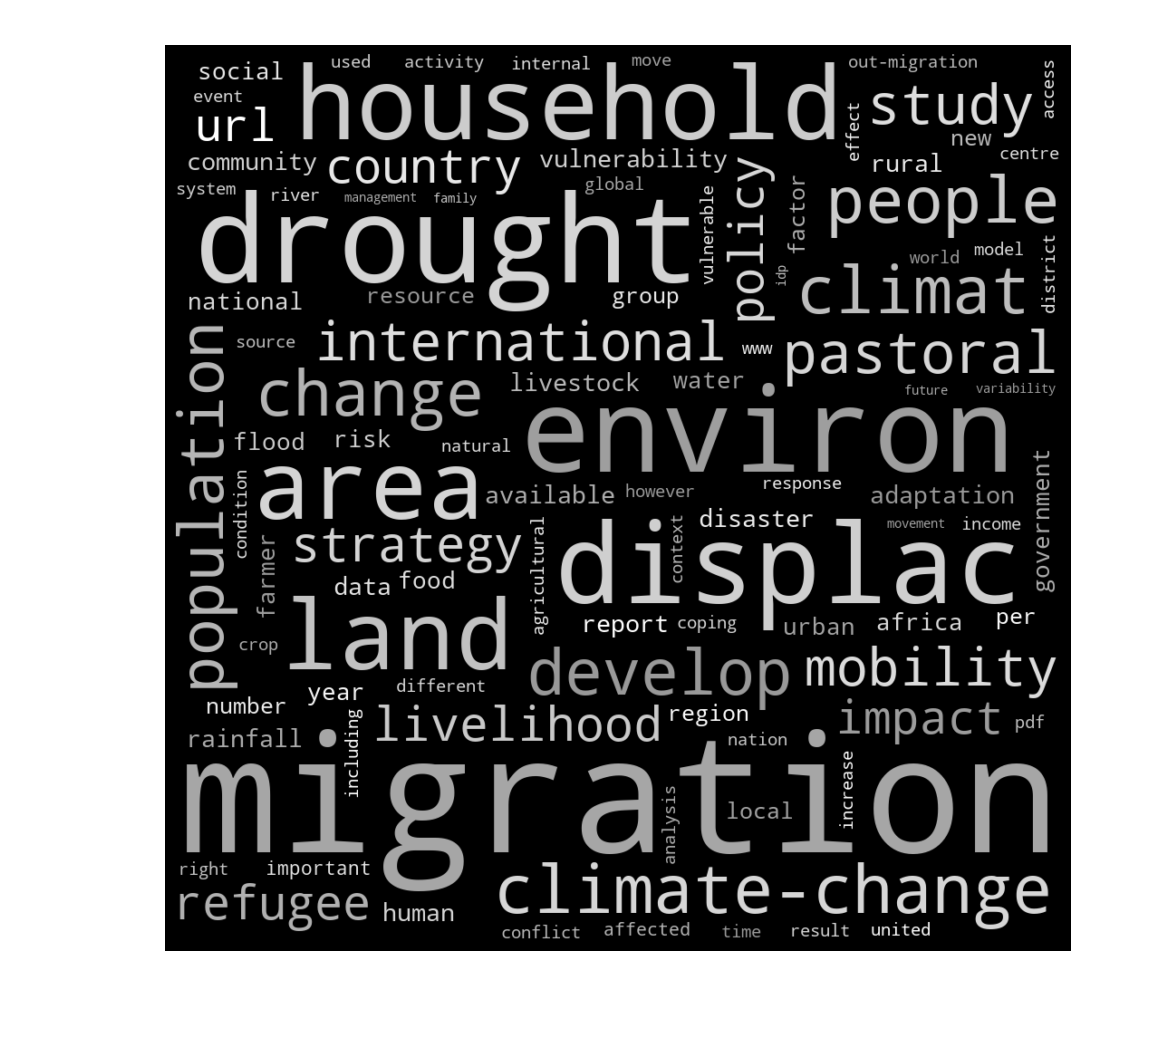

In [345]:
import random

from wordcloud import WordCloud #, STOPWORDS 

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
plt.rcParams['figure.dpi'] = 300

# read the mask image
# afr_mask = np.array(Image.open(path.join(d, "afr_mask.png")))

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
# See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py|
wc = WordCloud(background_color='black',
               #mask=alice_mask,
               #contour_width=3, contour_color='red',
               #stopwords=sw,
               width=1000, height=1000, 
               max_words=100, 
#                relative_scaling=0.95, 
               normalize_plurals=True,
               margin=20,
               min_font_size=1, max_font_size=500)
               #colormap="Greens")

corpus_word_freq['migration'] = corpus_word_freq.pop('migra')

wc.generate_from_frequencies(corpus_word_freq)

# store to file
# wc.to_file(path.join(d, "wordcloud_top100_words.png"))

plt.imshow(wc.recolor(color_func=grey_color_func, random_state=10), interpolation='bilinear')
# plt.imshow(wc, interpolation='bilinear')

plt.axis("off")
# plt.figure()
plt.savefig('wordcloud_square.png', bbox_inches='tight')
plt.show()

<Figure size 1800x1200 with 0 Axes>

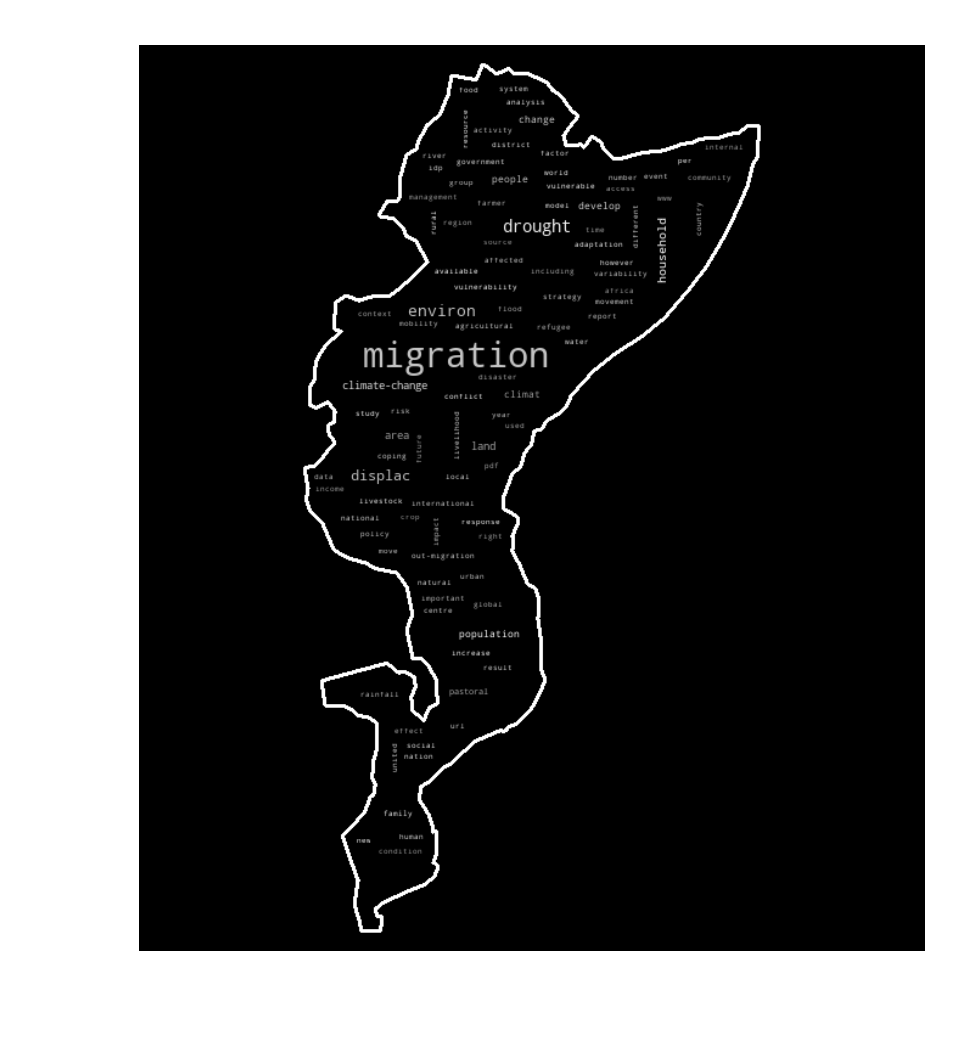

<Figure size 1800x1200 with 0 Axes>

In [346]:
import random

from wordcloud import WordCloud #, STOPWORDS 

from os import path
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
plt.rcParams['figure.dpi'] = 300

# read the mask image
afr_mask = np.array(Image.open("wordcloud_mask_eafr.png"))

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
# See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py|
wrdcld = WordCloud(background_color='black',
               mask=afr_mask,
               contour_width=2, contour_color='white',
               #stopwords=sw,
               width=1000, height=1000, 
               max_words=100, 
               relative_scaling=1, 
               normalize_plurals=True,
               margin=10)

wrdcld.generate_from_frequencies(corpus_word_freq)

# store to file
# wc.to_file(path.join(d, "wordcloud_top100_words.png"))

plt.imshow(wrdcld.recolor(color_func=grey_color_func, random_state=5), interpolation='bilinear')
plt.axis("off")
plt.figure()

# plt.imshow(afr_mask, cmap=plt.cm.gray, interpolation='bilinear')
# plt.axis("off")
# plt.show()

---
<a name="tf-idf"></a> 
# Term Frequency - Inverse Document Frequency ([TF-IDF](https://youtu.be/EjH9cEoEup8))

[TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) can be used to score of a word to rank its importance.

**Term Frequency (TF)**: is frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own TF.

**Inverse Data Frequency (IDF)**: is the weight of *rare* words across all documents in the corpus. Words that occur rarely (i.e. uncommon words, non-stop words) in the corpus have a high IDF score (= more significance).

The TF-IDF score of a word, w, is:

$$tf(w) * idf(w)$$

Where tf(w) = (Number of times the word appears in a document) / (Total number of words in the document)

And where idf(w) = log(Number of documents / Number of documents that contain word w ).

In [347]:
def tf(word, blob):
    """
    Computes "`t`erm `f`requency" which is the number of times a word (topic) appears in a 
    document blob, normalised by dividing by the total number of words in blob.
    """
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob, tokens in bloblist if word in blob.words)

def idf(word, bloblist):
    """
    Computes "`i`nverse `d`ocument `f`requency". IDF measures how common a word (topic) is 
    among all documents (corpus). The more common a word (topic) is, the lower its `idf` score. 
    IDF is computed as a ratio of the total number of documents to the number of documents 
    containing a word (topic), take the log of that and add 1 to the divisor to prevent 
    division by zero.
    """
    return np.log(len(bloblist) / 1 + n_containing(word, bloblist))

def tfidf(word, blob, bloblist):
    """Computes the `TF-IDF` score. It's the product of `tf` and `idf`.
    """
    return tf(word, blob) * idf(word, bloblist)

---

In [348]:
def plot_heatmap(df, plt_size_w=20, plt_size_h=7, 
                 plt_xlabel='x_axis', plt_ylabel='y_axis', 
                 plt_title='title',
                 plt_annotate=False,
                 plt_cmap='YlGnBu', show_plot_only=False):
    '''df: Pandas DataFrame (e.g. topic keyword (frequency | TF-IDF) x document)
    '''
    import seaborn as sns
    %matplotlib inline

    # df_tkw_freq = df_tkw_freq[:-5]
    df = df
    # df.replace('sum', 'corpus')
    display(df)

    plt.figure(figsize=(plt_size_w, plt_size_h))

    # sns.heatmap(df, annot=False, fmt="g", cmap='viridis')
    sns.heatmap(df, annot=plt_annotate, fmt='g', cmap=plt_cmap) # cmap='Greys', cmap='YlGnBu', cmap='viridis', linewidths=.1

    plt.tight_layout()
    plt.xlabel(plt_xlabel)  # 'Keyword'
    plt.ylabel(plt_ylabel)  # 'Document'
    plt.title(plt_title)  # 'Word frequency by document'
    
    if not show_plot_only:
        plt_title = re.sub(r'\s?[\(\)-:]\s?', "_", plt_title).replace(' ', '_').lower()
        print(plt_title)
        plt.savefig('{}.png'.format(plt_title), bbox_inches='tight')
        plt.show()
#         plt.close()
    else:
        plt.show()

## Frequency: Document, Topic Keyword
-----

In [349]:
def count_keywords_in_text(text, words):
    for k,v in words.items():
        ct = text.count(k)
        words[k] = ct
    return words

In [350]:
def compute_topic_keyword_frequency(topics, unique=False, export_topics=False):
    dfs = []

#     for topic_name, topic_keyword in topics.items():
    for topic_keyword in topics:
        topic_keyword = topic_keyword[:-1] if topic_keyword.endswith('*') else topic_keyword
        print(topic_keyword)
        df_kw_freq = pd.DataFrame()
        
        for dsr, (blob, tokens) in document_text.items():
            res = count_keywords_in_text(' '.join(tokens), {topic_keyword: 0})
            new_df = pd.DataFrame([res])
            df_kw_freq = df_kw_freq.append(new_df, ignore_index=True)

#         df_kw_freq.round(2)
#         df_kw_freq.loc['sum'] = pd.Series(df_kw_freq[topic_keyword].sum().round(2))
#         df_kw_freq.loc['mean'] = pd.Series(df_kw_freq[topic_keyword].mean().round(2))
#         df_kw_freq.loc['median'] = pd.Series(df_kw_freq[topic_keyword].mean().round(2))
#         df_kw_freq.loc['min'] = pd.Series(df_kw_freq[topic_keyword].min().round(2))
#         df_kw_freq.loc['max'] = pd.Series(df_kw_freq[topic_keyword].max().round(2))

#         stats = ['corpus', 'mean', 'median', 'min', 'max']
        dsrs = [dsr for dsr in document_text.keys()]
#         dsrs.extend(stats)

        df_kw_freq['dsr'] = dsrs
        df_kw_freq.set_index('dsr',inplace=True)

        dfs.append(df_kw_freq)
        
    return dfs
    
# print(compute_topic_keyword_frequency(topic_keywords, export_topics=True))
# display(compute_topic_keyword_frequency(topic_keywords_only))

# dfs = compute_topic_keyword_frequency(topic_keywords_only)
df_tkw_freq = reduce(lambda x, y: pd.merge(x, y, on = 'dsr'), compute_topic_keyword_frequency(topic_keywords_only))

migra
displac
mobility
pastoral
refugee
climat
climate-change
drought
environ
rainfall
disaster
temperatur
land
food
food-security
livestock
rural
famine
water
conflict
war
fragil
protection
security
risk
arm
develop
household
poverty
econ
social
livelihood
family
education
marriage
community


,migra,displac,mobility,pastoral,refugee,climat,climate-change,drought,environ,rainfall,disaster,temperatur,land,food,food-security,livestock,rural,famine,water,conflict,war,fragil,protection,security,risk,arm,develop,household,poverty,econ,social,livelihood,family,education,marriage,community
dsr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HG19,200,1,19,2,0,40,9,144,36,16,1,1,50,32,3,17,31,5,3,1,7,0,0,7,13,54,12,100,7,9,7,57,13,5,1,0
GW16,120,3,4,0,2,102,14,1,20,2,2,49,5,0,0,0,9,0,0,2,0,0,0,0,2,1,7,45,2,7,3,0,0,2,1,1
NS16,389,161,35,117,63,226,80,120,244,48,110,22,315,38,6,48,49,8,83,47,21,0,47,49,63,54,226,26,35,35,71,65,18,33,0,74
ST11,82,46,0,0,26,19,15,12,74,0,10,0,18,4,0,0,3,0,8,0,5,0,3,2,6,5,13,0,0,2,7,7,5,0,0,5
TA11,377,5,57,15,2,78,71,16,135,8,5,2,70,12,3,10,91,0,27,6,13,11,2,8,12,126,59,29,28,49,28,59,19,9,0,14
GM12,114,9,126,0,6,23,8,210,55,45,3,1,36,13,0,15,51,3,3,0,3,0,0,3,25,8,26,115,8,4,13,5,4,3,35,66
EK01,278,0,11,0,0,0,0,33,12,0,0,0,21,23,3,4,53,30,0,1,7,0,0,7,11,20,22,111,4,6,9,1,17,9,27,36
AL14,82,1,13,3,1,23,5,15,18,42,0,2,39,44,7,17,1,0,22,0,0,0,0,30,4,30,13,53,1,11,4,13,2,4,0,26
OP13,15,0,0,0,0,32,16,3,11,5,6,2,23,44,0,22,2,0,28,0,6,0,0,6,6,38,24,100,3,14,8,18,4,6,0,9


topic_all_word_frequency_by_document


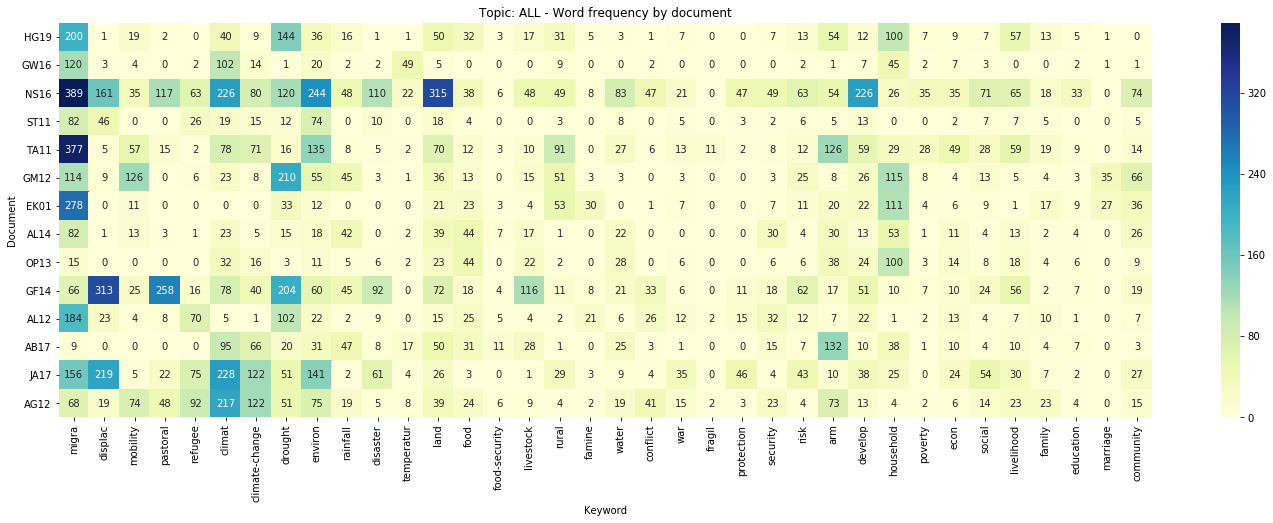

In [351]:
plot_heatmap(df_tkw_freq, 
             plt_xlabel='Keyword', plt_ylabel='Document', 
             plt_title='Topic: ALL - Word frequency by document', 
             plt_annotate=True, 
             show_plot_only=False)

# import seaborn as sns
# %matplotlib inline

# # df_tkw_freq = df_tkw_freq[:-5]
# df_tkw_freq = df_tkw_freq
# # df.replace('sum', 'corpus')
# display(df_tkw_freq)

# plt.figure(figsize=(20, 7))

# # sns.heatmap(df, annot=False, fmt="g", cmap='viridis')
# sns.heatmap(df_tkw_freq, annot=True, fmt='g', cmap='YlGnBu') # cmap='Greys', cmap='YlGnBu', cmap='viridis', linewidths=.1

# plt.tight_layout()
# plt.xlabel('Keyword')
# plt.ylabel('Document')
# plt.title('Word frequency by document')

# plt.show()

topic: HUMAN_MOBILITY, keywords: ['migra', 'displac', 'mobility', 'pastoral', 'refugee']
migra
displac
mobility
pastoral
refugee


,migra,displac,mobility,pastoral,refugee
dsr,,,,,
HG19,200,1,19,2,0
GW16,120,3,4,0,2
NS16,389,161,35,117,63
ST11,82,46,0,0,26
TA11,377,5,57,15,2
GM12,114,9,126,0,6
EK01,278,0,11,0,0
AL14,82,1,13,3,1
OP13,15,0,0,0,0


topic_human_mobility_word_frequency_by_document


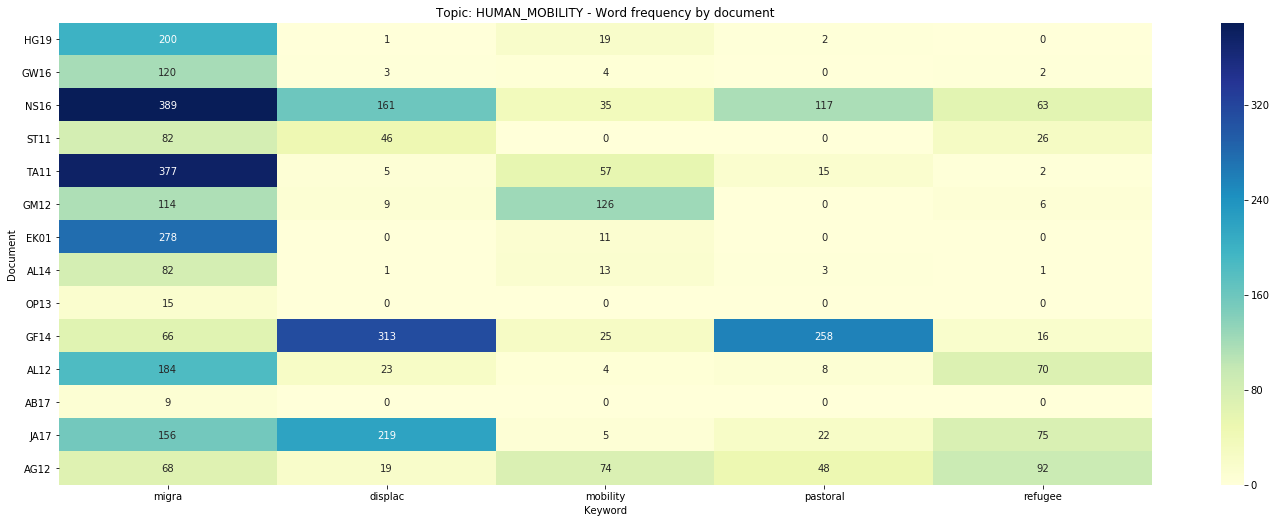

topic: CLIMATE, keywords: ['climat', 'climate-change', 'drought', 'environ', 'rainfall', 'disaster', 'temperatur']
climat
climate-change
drought
environ
rainfall
disaster
temperatur


,climat,climate-change,drought,environ,rainfall,disaster,temperatur
dsr,,,,,,,
HG19,40,9,144,36,16,1,1
GW16,102,14,1,20,2,2,49
NS16,226,80,120,244,48,110,22
ST11,19,15,12,74,0,10,0
TA11,78,71,16,135,8,5,2
GM12,23,8,210,55,45,3,1
EK01,0,0,33,12,0,0,0
AL14,23,5,15,18,42,0,2
OP13,32,16,3,11,5,6,2


topic_climate_word_frequency_by_document


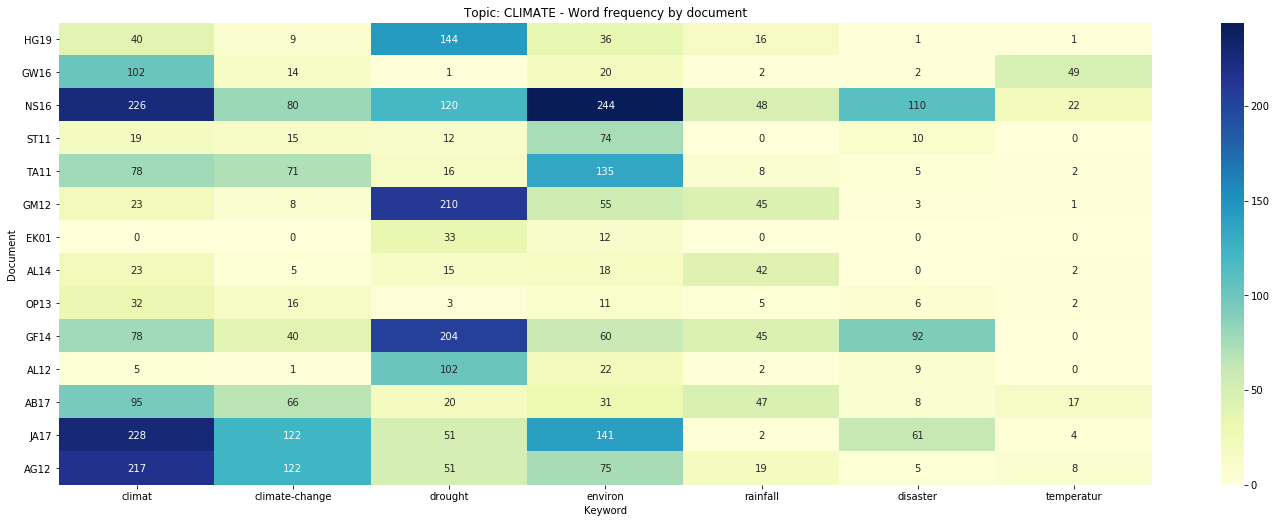

topic: FOOD_SECURITY, keywords: ['land', 'food', 'food-security', 'livestock', 'rural', 'pastoral', 'famine', 'water']
land
food
food-security
livestock
rural
pastoral
famine
water


,land,food,food-security,livestock,rural,pastoral,famine,water
dsr,,,,,,,,
HG19,50,32,3,17,31,2,5,3
GW16,5,0,0,0,9,0,0,0
NS16,315,38,6,48,49,117,8,83
ST11,18,4,0,0,3,0,0,8
TA11,70,12,3,10,91,15,0,27
GM12,36,13,0,15,51,0,3,3
EK01,21,23,3,4,53,0,30,0
AL14,39,44,7,17,1,3,0,22
OP13,23,44,0,22,2,0,0,28


topic_food_security_word_frequency_by_document


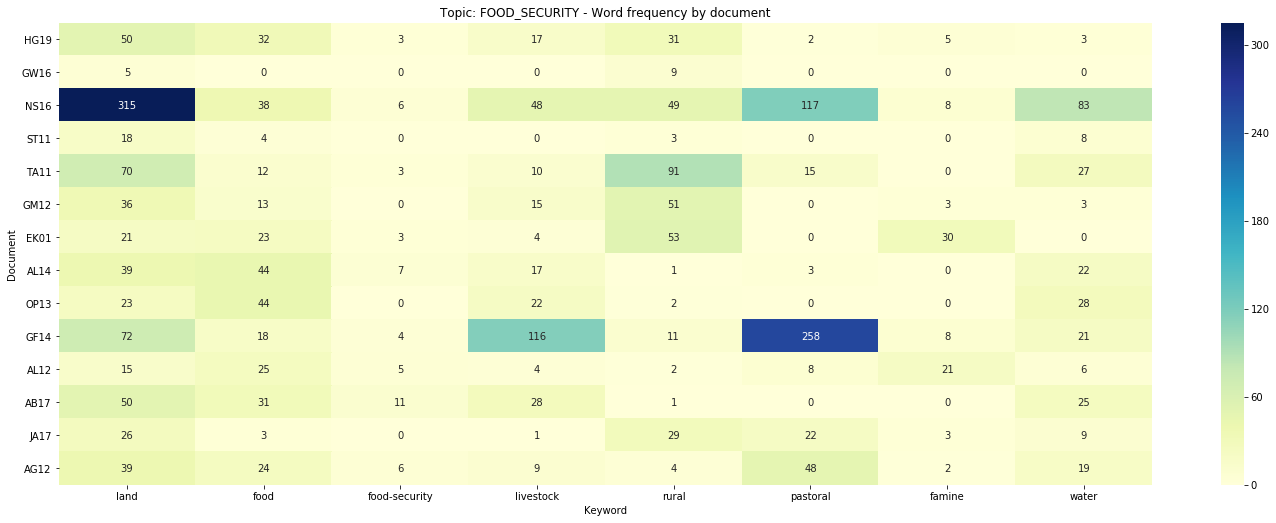

topic: CONFLICT, keywords: ['conflict', 'war*', 'fragil', 'protection', 'security', 'risk', 'water', 'arm']
conflict
war
fragil
protection
security
risk
water
arm


,conflict,war,fragil,protection,security,risk,water,arm
dsr,,,,,,,,
HG19,1,7,0,0,7,13,3,54
GW16,2,0,0,0,0,2,0,1
NS16,47,21,0,47,49,63,83,54
ST11,0,5,0,3,2,6,8,5
TA11,6,13,11,2,8,12,27,126
GM12,0,3,0,0,3,25,3,8
EK01,1,7,0,0,7,11,0,20
AL14,0,0,0,0,30,4,22,30
OP13,0,6,0,0,6,6,28,38


topic_conflict_word_frequency_by_document


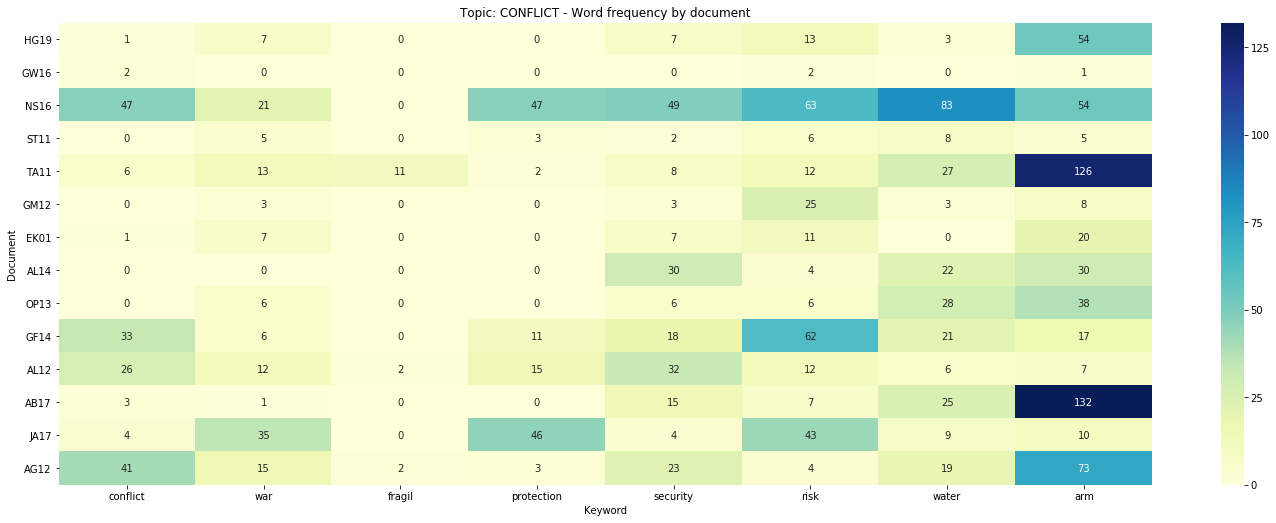

topic: ECONOMY, keywords: ['develop', 'household', 'livestock', 'pastoral', 'poverty', 'econ*']
develop
household
livestock
pastoral
poverty
econ


,develop,household,livestock,pastoral,poverty,econ
dsr,,,,,,
HG19,12,100,17,2,7,9
GW16,7,45,0,0,2,7
NS16,226,26,48,117,35,35
ST11,13,0,0,0,0,2
TA11,59,29,10,15,28,49
GM12,26,115,15,0,8,4
EK01,22,111,4,0,4,6
AL14,13,53,17,3,1,11
OP13,24,100,22,0,3,14


topic_economy_word_frequency_by_document


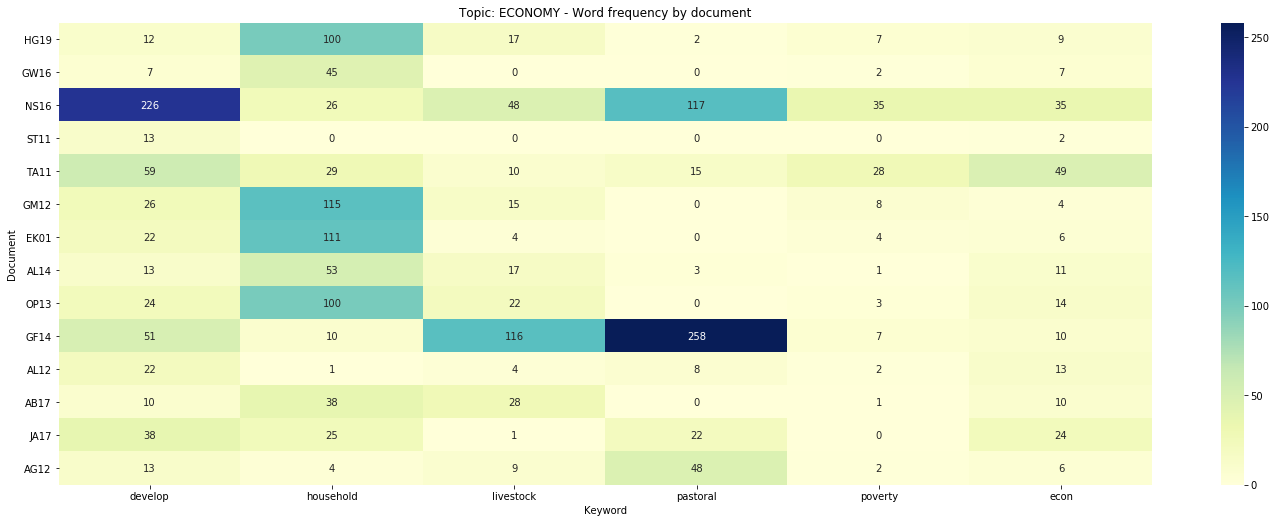

topic: SOCIAL_NORMS, keywords: ['social', 'livelihood', 'family', 'education', 'marriage', 'community']
social
livelihood
family
education
marriage
community


,social,livelihood,family,education,marriage,community
dsr,,,,,,
HG19,7,57,13,5,1,0
GW16,3,0,0,2,1,1
NS16,71,65,18,33,0,74
ST11,7,7,5,0,0,5
TA11,28,59,19,9,0,14
GM12,13,5,4,3,35,66
EK01,9,1,17,9,27,36
AL14,4,13,2,4,0,26
OP13,8,18,4,6,0,9


topic_social_norms_word_frequency_by_document


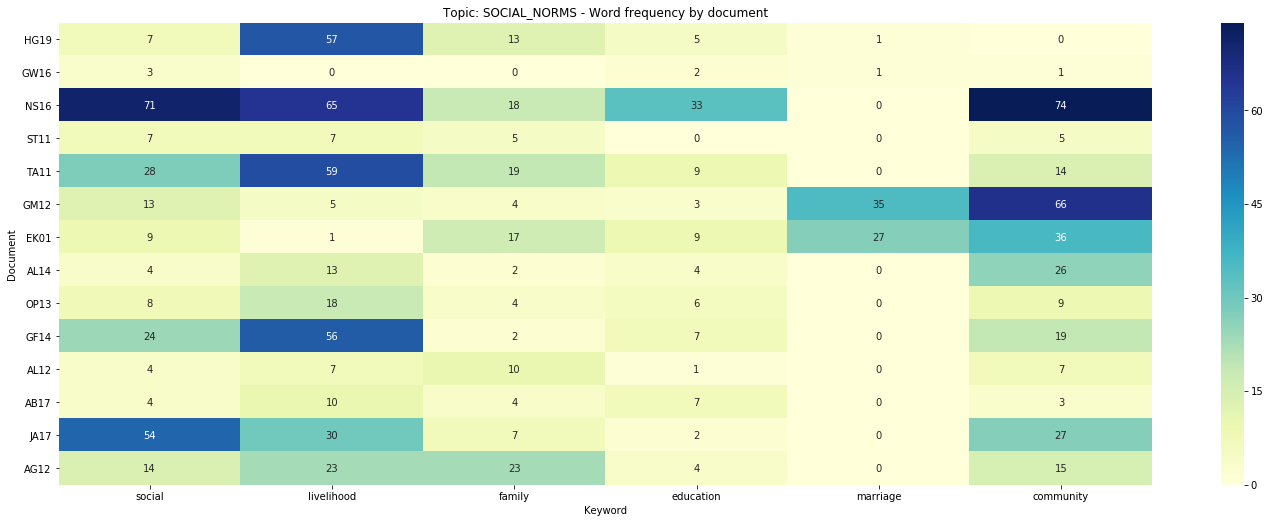

In [352]:
for topic, keywords in topic_keywords.items():
    print('topic: {}, keywords: {}'.format(topic, keywords))
    df_tkw_freq = reduce(lambda x, y: pd.merge(x, y, on = 'dsr'), compute_topic_keyword_frequency(keywords))
    
    plot_heatmap(df_tkw_freq, 
                 plt_xlabel='Keyword', plt_ylabel='Document', 
                 plt_title='Topic: {} - Word frequency by document'.format(topic), 
                 plt_annotate=True, 
                 show_plot_only=False)
# df_tkw_freq = reduce(lambda x, y: pd.merge(x, y, on = 'dsr'), compute_topic_keyword_frequency(topic_keywords_only))

## TF-IDF: Document, Topic Keyword
----

In [353]:
def compute_topic_keyword_tfidf(topics, unique=False, export_topics=False):
    dfs = []

#     for topic_name, topic_keyword in topics.items():
    for topic_keyword in topics:
        topic_keyword = topic_keyword[:-1] if topic_keyword.endswith('*') else topic_keyword
        print(topic_keyword)
        df_kw_freq = pd.DataFrame()
#         for k, v in document_tokens_normalised.items():
        for dsr, (blob, tokens) in document_text.items():
            res = {}
            res[topic_keyword] = tfidf(topic_keyword, blob, list(document_text.values()))
            new_df = pd.DataFrame([res])
            df_kw_freq = df_kw_freq.append(new_df, ignore_index=True)

#         df_kw_freq.round(2)
#         df_kw_freq.loc['sum'] = pd.Series(df_kw_freq[topic_keyword].sum().round(2))
#         df_kw_freq.loc['mean'] = pd.Series(df_kw_freq[topic_keyword].mean().round(2))
#         df_kw_freq.loc['median'] = pd.Series(df_kw_freq[topic_keyword].mean().round(2))
#         df_kw_freq.loc['min'] = pd.Series(df_kw_freq[topic_keyword].min().round(2))
#         df_kw_freq.loc['max'] = pd.Series(df_kw_freq[topic_keyword].max().round(2))

#         stats = ['corpus', 'mean', 'median', 'min', 'max']
        dsrs = [dsr for dsr in document_text.keys()]
#         dsrs.extend(stats)

        df_kw_freq['dsr'] = dsrs
        df_kw_freq.set_index('dsr',inplace=True)

        dfs.append(df_kw_freq)
          
    return dfs
    
# print(compute_topic_keyword_frequency(topic_keywords, export_topics=True))
# compute_topic_keyword_tfidf(topic_keywords_only)

df_tkw_tfidf = reduce(lambda x, y: pd.merge(x, y, on = 'dsr'), compute_topic_keyword_tfidf(topic_keywords_only))

migra
displac
mobility
pastoral
refugee
climat
climate-change
drought
environ
rainfall
disaster
temperatur
land
food
food-security
livestock
rural
famine
water
conflict
war
fragil
protection
security
risk
arm
develop
household
poverty
econ
social
livelihood
family
education
marriage
community


In [354]:
# import seaborn as sns
# %matplotlib inline

# # df_tkw_freq = df_tkw_freq[:-5]
# display(df_tkw_tfidf)

# plt.figure(figsize=(20, 7))

# # sns.heatmap(df, annot=False, fmt="g", cmap='viridis')
# sns.heatmap(df_tkw_tfidf, annot=False, fmt='g', cmap='YlGnBu') # cmap='Greys', cmap='YlGnBu', cmap='viridis', linewidths=.1

# plt.tight_layout()
# plt.xlabel('Keyword')
# plt.ylabel('Document')
# plt.title('Word frequency by document')

# plt.show()

,migra,displac,mobility,pastoral,refugee,climat,climate-change,drought,environ,rainfall,disaster,temperatur,land,food,food-security,livestock,rural,famine,water,conflict,war,fragil,protection,security,risk,arm,develop,household,poverty,econ,social,livelihood,family,education,marriage,community
dsr,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HG19,0.109140,0.000602,0.009639,0.000000,0.000000,0.012954,0.005552,0.076710,0.018710,0.009757,0.000610,0.000595,0.011850,0.017272,0.001761,0.010366,0.019333,0.002314,0.001829,0.000595,0.000000,0.000000,0.000000,0.001234,0.006237,0.000000,0.006237,0.061685,0.004269,0.001623,0.004366,0.035161,0.008019,0.003084,0.000541,0.000000
GW16,0.140205,0.003386,0.004515,0.000000,0.002229,0.082049,0.016179,0.001168,0.011684,0.002285,0.002285,0.054602,0.003505,0.000000,0.000000,0.000000,0.010515,0.000000,0.000000,0.001114,0.000000,0.000000,0.000000,0.000000,0.002337,0.000000,0.008179,0.039291,0.002285,0.006081,0.003505,0.000000,0.000000,0.002311,0.001013,0.001156
NS16,0.045440,0.018626,0.004559,0.012812,0.007845,0.017737,0.010136,0.014697,0.032091,0.006065,0.013975,0.002829,0.036271,0.003868,0.000761,0.006328,0.005798,0.001001,0.009360,0.005530,0.000121,0.000000,0.005544,0.004534,0.006202,0.000500,0.027102,0.003467,0.004351,0.000000,0.009573,0.008402,0.002401,0.004401,0.000000,0.009602
ST11,0.064882,0.034820,0.000000,0.000000,0.018335,0.003169,0.011884,0.009612,0.046459,0.000000,0.007832,0.000000,0.012015,0.003169,0.000000,0.000000,0.002403,0.000000,0.006266,0.000000,0.000000,0.000000,0.002196,0.001585,0.004806,0.000743,0.010413,0.000000,0.000000,0.000000,0.005607,0.005546,0.003961,0.000000,0.000000,0.003961
TA11,0.105752,0.001637,0.018336,0.004645,0.000647,0.002347,0.023467,0.005423,0.038301,0.002651,0.001657,0.000647,0.017286,0.003017,0.000957,0.003314,0.018981,0.000000,0.008285,0.001293,0.000000,0.003170,0.000619,0.001676,0.004067,0.000000,0.019998,0.009722,0.009279,0.000000,0.009491,0.019780,0.006370,0.003017,0.000000,0.004358
GM12,0.056441,0.004811,0.067349,0.000000,0.002639,0.006020,0.004378,0.115648,0.024900,0.024346,0.001623,0.000528,0.011620,0.006020,0.000000,0.008115,0.027114,0.001027,0.001623,0.000000,0.000995,0.000000,0.000000,0.001095,0.009960,0.001027,0.014387,0.058014,0.004328,0.000000,0.007193,0.002736,0.002189,0.001642,0.013919,0.030649
EK01,0.119462,0.000000,0.007511,0.000000,0.000000,0.000000,0.000000,0.023327,0.008482,0.000000,0.000000,0.000000,0.012724,0.013983,0.001995,0.002765,0.028982,0.019671,0.000000,0.000674,0.003813,0.000000,0.000000,0.000699,0.007776,0.001967,0.015551,0.074810,0.002765,0.000000,0.006362,0.000699,0.011886,0.006292,0.016555,0.024471
AL14,0.075005,0.001066,0.012786,0.003023,0.001052,0.016365,0.005455,0.016545,0.019854,0.042061,0.000000,0.002104,0.027575,0.040366,0.007265,0.018334,0.001103,0.000000,0.023727,0.000000,0.000000,0.000000,0.000000,0.005455,0.004412,0.000000,0.014339,0.057822,0.001078,0.000957,0.004412,0.014183,0.002182,0.004364,0.000000,0.028365
OP13,0.012856,0.000000,0.000000,0.000000,0.000000,0.011868,0.011868,0.002571,0.009428,0.004190,0.005028,0.001635,0.017141,0.035603,0.000000,0.018436,0.001714,0.000000,0.021788,0.000000,0.000000,0.000000,0.000000,0.005086,0.005142,0.000000,0.020569,0.083922,0.002514,0.000000,0.006856,0.015259,0.003391,0.005086,0.000000,0.007629


topic_all_tf_idf_by_document


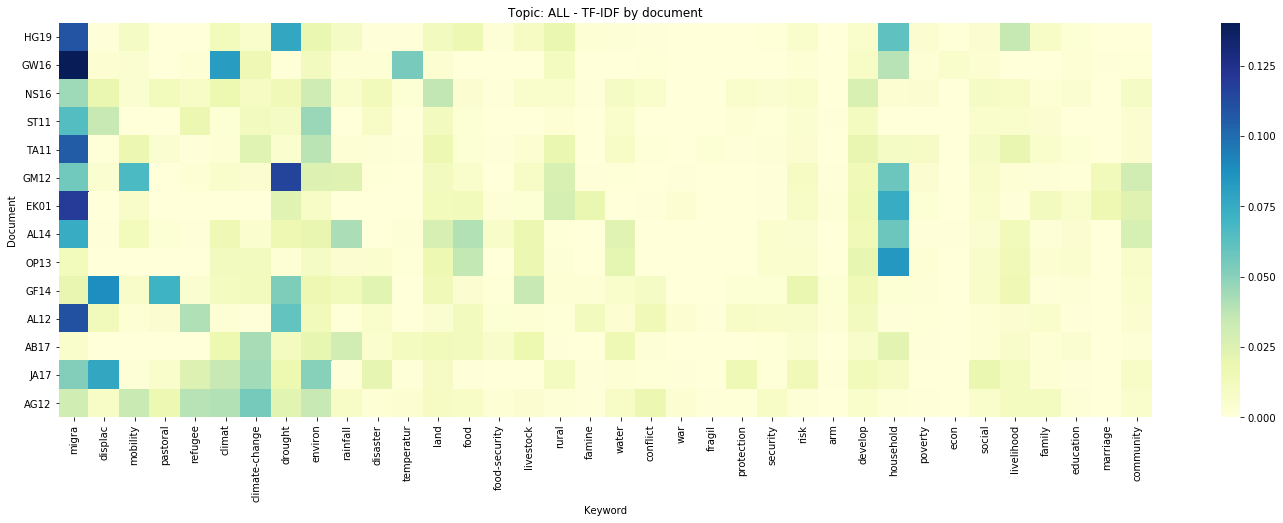

In [355]:
plot_heatmap(df_tkw_tfidf, 
             plt_xlabel='Keyword', plt_ylabel='Document', 
             plt_title='Topic: ALL - TF-IDF by document', 
             show_plot_only=False)

topic: HUMAN_MOBILITY, keywords: ['migra', 'displac', 'mobility', 'pastoral', 'refugee']
migra
displac
mobility
pastoral
refugee


,migra,displac,mobility,pastoral,refugee
dsr,,,,,
HG19,0.109140,0.000602,0.009639,0.000000,0.000000
GW16,0.140205,0.003386,0.004515,0.000000,0.002229
NS16,0.045440,0.018626,0.004559,0.012812,0.007845
ST11,0.064882,0.034820,0.000000,0.000000,0.018335
TA11,0.105752,0.001637,0.018336,0.004645,0.000647
GM12,0.056441,0.004811,0.067349,0.000000,0.002639
EK01,0.119462,0.000000,0.007511,0.000000,0.000000
AL14,0.075005,0.001066,0.012786,0.003023,0.001052
OP13,0.012856,0.000000,0.000000,0.000000,0.000000


topic_human_mobility_tf_idf_by_document


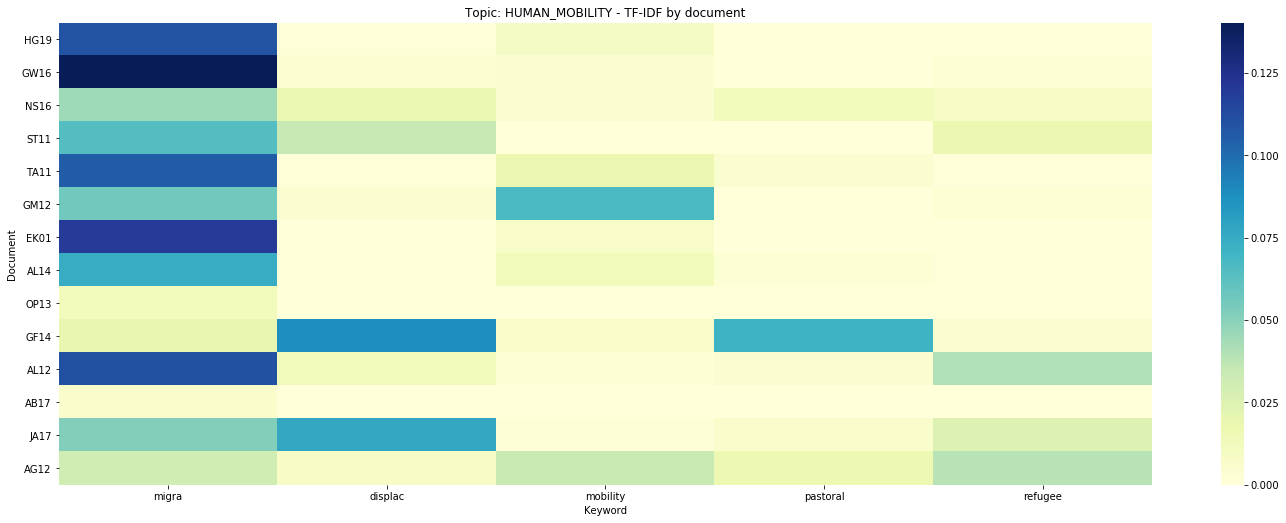

topic: CLIMATE, keywords: ['climat', 'climate-change', 'drought', 'environ', 'rainfall', 'disaster', 'temperatur']
climat
climate-change
drought
environ
rainfall
disaster
temperatur


,climat,climate-change,drought,environ,rainfall,disaster,temperatur
dsr,,,,,,,
HG19,0.012954,0.005552,0.076710,0.018710,0.009757,0.000610,0.000595
GW16,0.082049,0.016179,0.001168,0.011684,0.002285,0.002285,0.054602
NS16,0.017737,0.010136,0.014697,0.032091,0.006065,0.013975,0.002829
ST11,0.003169,0.011884,0.009612,0.046459,0.000000,0.007832,0.000000
TA11,0.002347,0.023467,0.005423,0.038301,0.002651,0.001657,0.000647
GM12,0.006020,0.004378,0.115648,0.024900,0.024346,0.001623,0.000528
EK01,0.000000,0.000000,0.023327,0.008482,0.000000,0.000000,0.000000
AL14,0.016365,0.005455,0.016545,0.019854,0.042061,0.000000,0.002104
OP13,0.011868,0.011868,0.002571,0.009428,0.004190,0.005028,0.001635


topic_climate_tf_idf_by_document


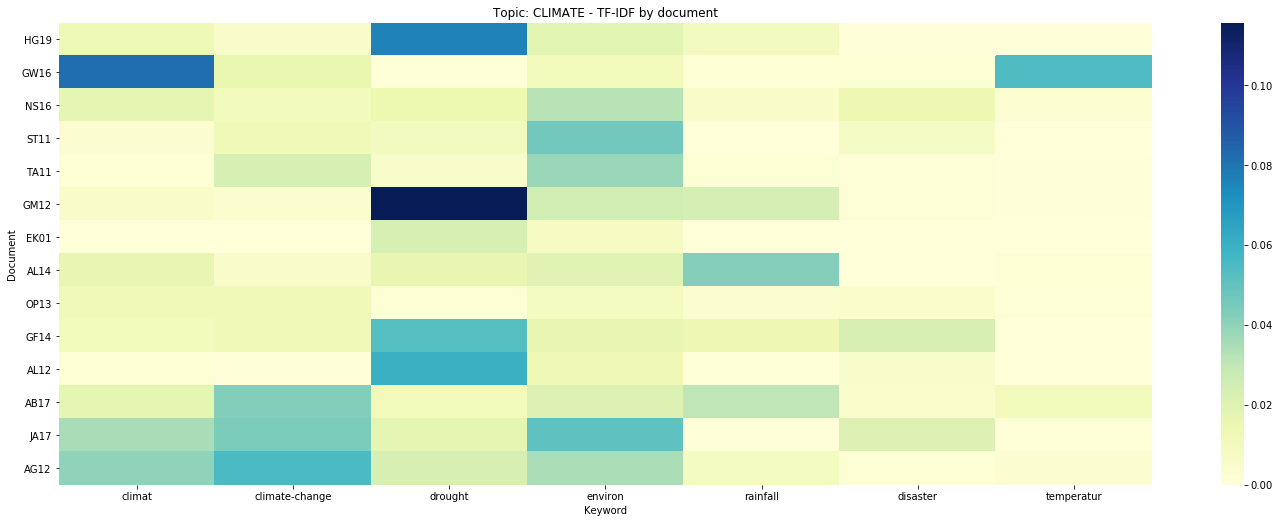

topic: FOOD_SECURITY, keywords: ['land', 'food', 'food-security', 'livestock', 'rural', 'pastoral', 'famine', 'water']
land
food
food-security
livestock
rural
pastoral
famine
water


,land,food,food-security,livestock,rural,pastoral,famine,water
dsr,,,,,,,,
HG19,0.011850,0.017272,0.001761,0.010366,0.019333,0.000000,0.002314,0.001829
GW16,0.003505,0.000000,0.000000,0.000000,0.010515,0.000000,0.000000,0.000000
NS16,0.036271,0.003868,0.000761,0.006328,0.005798,0.012812,0.001001,0.009360
ST11,0.012015,0.003169,0.000000,0.000000,0.002403,0.000000,0.000000,0.006266
TA11,0.017286,0.003017,0.000957,0.003314,0.018981,0.004645,0.000000,0.008285
GM12,0.011620,0.006020,0.000000,0.008115,0.027114,0.000000,0.001027,0.001623
EK01,0.012724,0.013983,0.001995,0.002765,0.028982,0.000000,0.019671,0.000000
AL14,0.027575,0.040366,0.007265,0.018334,0.001103,0.003023,0.000000,0.023727
OP13,0.017141,0.035603,0.000000,0.018436,0.001714,0.000000,0.000000,0.021788


topic_food_security_tf_idf_by_document


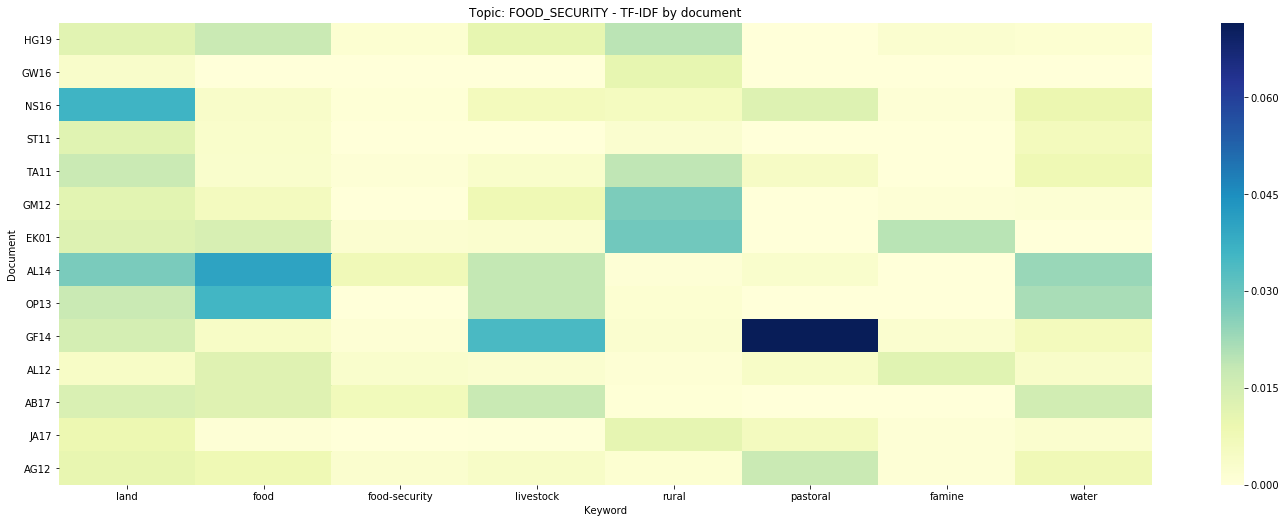

topic: CONFLICT, keywords: ['conflict', 'war*', 'fragil', 'protection', 'security', 'risk', 'water', 'arm']
conflict
war
fragil
protection
security
risk
water
arm


,conflict,war,fragil,protection,security,risk,water,arm
dsr,,,,,,,,
HG19,0.000595,0.000000,0.000000,0.000000,0.001234,0.006237,0.001829,0.000000
GW16,0.001114,0.000000,0.000000,0.000000,0.000000,0.002337,0.000000,0.000000
NS16,0.005530,0.000121,0.000000,0.005544,0.004534,0.006202,0.009360,0.000500
ST11,0.000000,0.000000,0.000000,0.002196,0.001585,0.004806,0.006266,0.000743
TA11,0.001293,0.000000,0.003170,0.000619,0.001676,0.004067,0.008285,0.000000
GM12,0.000000,0.000995,0.000000,0.000000,0.001095,0.009960,0.001623,0.001027
EK01,0.000674,0.003813,0.000000,0.000000,0.000699,0.007776,0.000000,0.001967
AL14,0.000000,0.000000,0.000000,0.000000,0.005455,0.004412,0.023727,0.000000
OP13,0.000000,0.000000,0.000000,0.000000,0.005086,0.005142,0.021788,0.000000


topic_conflict_tf_idf_by_document


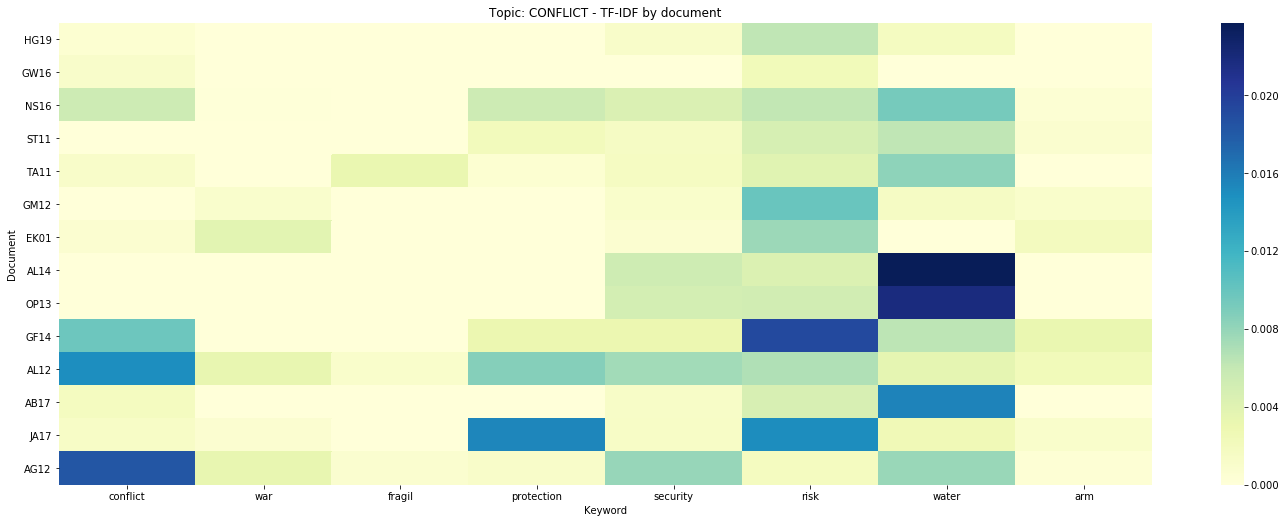

topic: ECONOMY, keywords: ['develop', 'household', 'livestock', 'pastoral', 'poverty', 'econ*']
develop
household
livestock
pastoral
poverty
econ


,develop,household,livestock,pastoral,poverty,econ
dsr,,,,,,
HG19,0.006237,0.061685,0.010366,0.000000,0.004269,0.001623
GW16,0.008179,0.039291,0.000000,0.000000,0.002285,0.006081
NS16,0.027102,0.003467,0.006328,0.012812,0.004351,0.000000
ST11,0.010413,0.000000,0.000000,0.000000,0.000000,0.000000
TA11,0.019998,0.009722,0.003314,0.004645,0.009279,0.000000
GM12,0.014387,0.058014,0.008115,0.000000,0.004328,0.000000
EK01,0.015551,0.074810,0.002765,0.000000,0.002765,0.000000
AL14,0.014339,0.057822,0.018334,0.003023,0.001078,0.000957
OP13,0.020569,0.083922,0.018436,0.000000,0.002514,0.000000


topic_economy_tf_idf_by_document


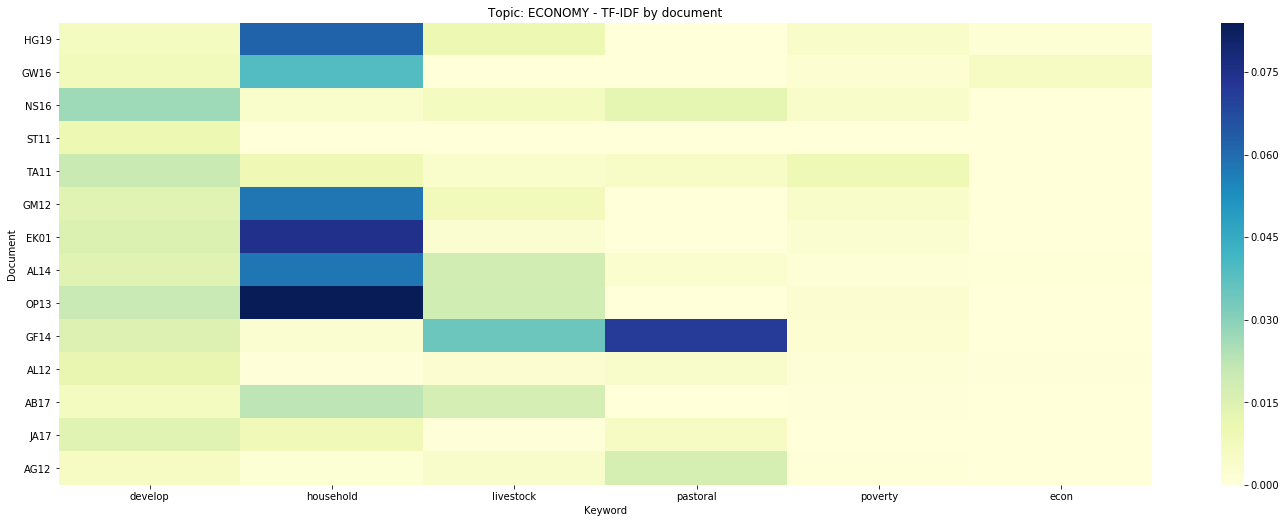

topic: SOCIAL_NORMS, keywords: ['social', 'livelihood', 'family', 'education', 'marriage', 'community']
social
livelihood
family
education
marriage
community


,social,livelihood,family,education,marriage,community
dsr,,,,,,
HG19,0.004366,0.035161,0.008019,0.003084,0.000541,0.000000
GW16,0.003505,0.000000,0.000000,0.002311,0.001013,0.001156
NS16,0.009573,0.008402,0.002401,0.004401,0.000000,0.009602
ST11,0.005607,0.005546,0.003961,0.000000,0.000000,0.003961
TA11,0.009491,0.019780,0.006370,0.003017,0.000000,0.004358
GM12,0.007193,0.002736,0.002189,0.001642,0.013919,0.030649
EK01,0.006362,0.000699,0.011886,0.006292,0.016555,0.024471
AL14,0.004412,0.014183,0.002182,0.004364,0.000000,0.028365
OP13,0.006856,0.015259,0.003391,0.005086,0.000000,0.007629


topic_social_norms_tf_idf_by_document


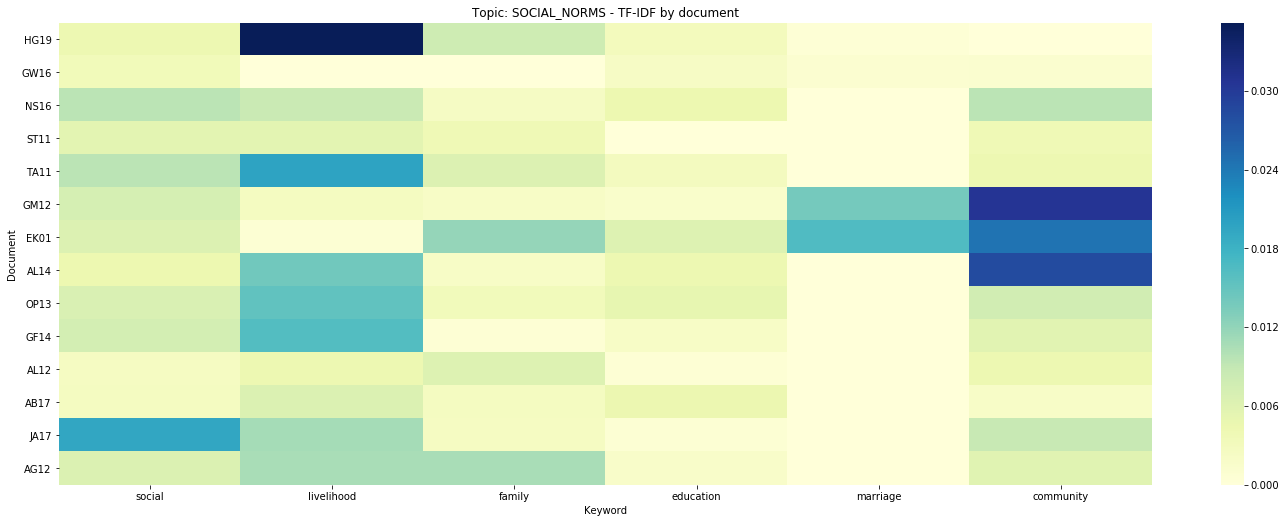

In [356]:
for topic, keywords in topic_keywords.items():
    print('topic: {}, keywords: {}'.format(topic, keywords))
    df_tkw_tfidf = reduce(lambda x, y: pd.merge(x, y, on = 'dsr'), compute_topic_keyword_tfidf(keywords))
    
    plot_heatmap(df_tkw_tfidf, 
                 plt_xlabel='Keyword', plt_ylabel='Document', 
                 plt_title='Topic: {} - TF-IDF by document'.format(topic),
                 show_plot_only=False)